In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
%matplotlib widget
import matplotlib.pyplot as plt

3d圖形範例 程式
確定有看到圖形之後就可以


C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


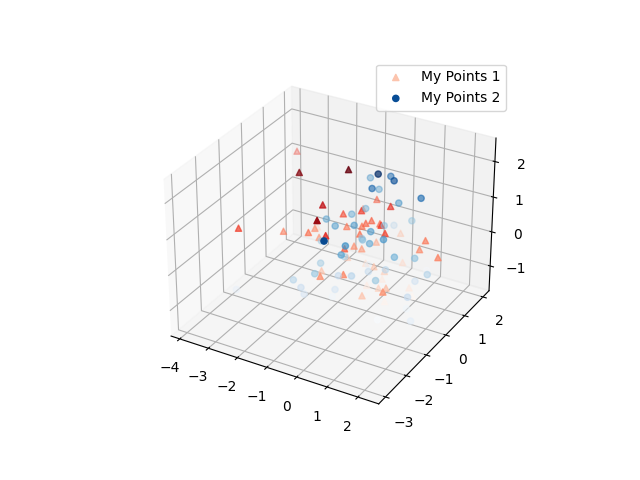

In [11]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.gca(projection='3d')

# 產生 3D 座標資料
z1 = np.random.randn(50)
x1 = np.random.randn(50)
y1 = np.random.randn(50)
z2 = np.random.randn(50)
x2 = np.random.randn(50)
y2 = np.random.randn(50)

# 繪製 3D 座標點
ax.scatter(x1, y1, z1, c=z1, cmap='Reds', marker='^', label='My Points 1')
ax.scatter(x2, y2, z2, c=z2, cmap='Blues', marker='o', label='My Points 2')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [3]:
#ICP Library functions code
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''
    #tolerance = 0.001
    #max_iterations=20
    #init_pose = None
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [29]:

A = np.random.randint(0,5,(10,3))    # 20 points for test

rotz = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0],
                                    [np.sin(theta),np.cos(theta),0],
                                    [0,0,1]])
trans = np.array([2.12,-0.2,1.3])
B = A.dot(rotz(np.pi/4).T) + trans
#print(B)
T, distances,i = icp(A, B)

np.set_printoptions(precision=3,suppress=True)
print(T)

[[ 0.707 -0.707 -0.     2.12 ]
 [ 0.707  0.707  0.    -0.2  ]
 [-0.    -0.     1.     1.3  ]
 [ 0.     0.     0.     1.   ]]


In [30]:
A_X= [i[0] for i in A]
#B_X =np.array([i[0] for i in B]).T
B_X =[i[0] for i in B]
A_Y = [i[1] for i in A]
#B_Y = np.array([i[1] for i in B]).T
B_Y = [i[1] for i in B]
A_Z = [i[2] for i in A]
#B_Z = np.array([i[2] for i in B]).T
B_Z = [i[2] for i in B]
#B_Y = np.array(B_Y)
#B_Y = B_Y.T
B_Y

[3.3355339059327376,
 3.3355339059327376,
 3.3355339059327376,
 2.62842712474619,
 2.62842712474619,
 4.749747468305833,
 1.2142135623730952,
 0.5071067811865475,
 3.3355339059327376,
 4.0426406871192855]

In [6]:
A

array([[76, 83, 93],
       [95, 56,  8],
       [70, 21, 56],
       [64, 21, 74],
       [64, 47, 16],
       [61, 50, 55],
       [87, 91, 50],
       [15, 51, 44],
       [92, 42, 99],
       [65, 18, 26]])

C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


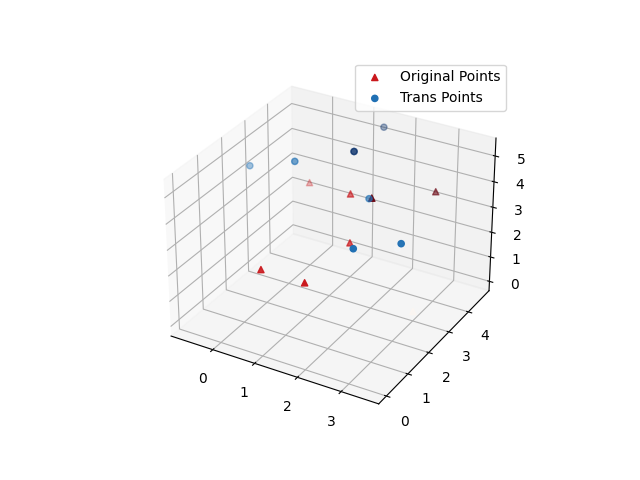

In [31]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.gca(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X, B_Y, B_Z, c=B_Z, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [27]:
T

array([[ 0.967,  0.041, -0.253,  0.951],
       [-0.2  ,  0.736, -0.646,  2.776],
       [ 0.16 ,  0.675,  0.72 , -0.575],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])